## Imports

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays

## Base

In [2]:
function ϕ₁(ξ::Float64)
    return (1.0 - ξ)/2.0
end

function ϕ₂(ξ::Float64)
    return (1.0 + ξ)/2.0
end

function dϕ₁(ξ::Float64)
    return -1.0/2.0
end

function dϕ₂(ξ::Float64)
    return 1.0/2.0
end

dϕ₂ (generic function with 1 method)

## Mapeamento

In [3]:
function map_index_to_coord(index::Int64, ne::Int64)::Float64
    return (index-1)/ne
end

function map_ξ_to_x(ξ::Float64, x_i_inf::Float64, h::Float64)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

map_ξ_to_x (generic function with 1 method)

## DoF Handlers

In [4]:
function monta_LG(ne::Int64)::Matrix{Int64}
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne::Int64)::Tuple{Int64, Vector{Int64}}
    m = ne-1
    return (m, vcat(m+1, 1:m, m+1))
end

monta_EQ (generic function with 1 method)

## Quadraturas

In [5]:
function quadrature_without_map(func1::Function, func2::Function, P::Vector{Float64}, W::Vector{Float64})::Float64
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W * (func1(ξ) * func2(ξ)) 
    end
    
    return quad
end

function quadrature_with_map(func1::Function, func2::Function, e::Int64, ne::Int64, P::Vector{Float64}, W::Vector{Float64})::Float64
    h = 1.0/ne
    x_i_inf = map_index_to_coord(e, ne)
    
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W*(func1(map_ξ_to_x(ξ, x_i_inf, h)) * func2(ξ)) 
    end
    
    return quad
end

function quadrature_non_linearity(func1::Function, func2::Function, e::Int64, c̄::Vector{Float64}, EQoLG::Matrix{Int64}, P::Vector{Float64}, W::Vector{Float64})::Float64
    
    quad = 0.0
    
    for (ξ, W) in zip(P, W)
         quad += W * ((func1(c̄[EQoLG[1, e]] * ϕ₁(ξ) + c̄[EQoLG[2, e]] * ϕ₂(ξ))) * func2(ξ))
    end
    
    return quad
end

quadrature_non_linearity (generic function with 1 method)

## Montagem local

In [6]:
function monta_F_local!(Fᵉ::Vector{Float64}, f::Function, e::Int64, ne::Int64, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Fᵉ[1] = h/2 * quadrature_with_map(f, ϕ₁, e, ne, P, W)
    Fᵉ[2] = h/2 * quadrature_with_map(f, ϕ₂, e, ne, P, W)

    return
end

function monta_K_local!(Kᵉ::Matrix{Float64}, α::Float64, β::Float64, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Kᵉ[1, 1] = (2*α/h) * quadrature_without_map(dϕ₁, dϕ₁, P, W) + (β*h/2) * quadrature_without_map(ϕ₁, ϕ₁, P, W)
    Kᵉ[1, 2] = (2*α/h) * quadrature_without_map(dϕ₁, dϕ₂, P, W) + (β*h/2) * quadrature_without_map(ϕ₁, ϕ₂, P, W)
    Kᵉ[2, 1] = Kᵉ[1, 2]
    Kᵉ[2, 2] = (2*α/h) * quadrature_without_map(dϕ₂, dϕ₂, P, W) + (β*h/2) * quadrature_without_map(ϕ₂, ϕ₂, P, W)    
    
    return
end

function monta_G_local!(Gᵉ::Vector{Float64}, g::Function, e::Int64, c̄::Vector{Float64}, EQoLG::Matrix{Int64}, h::Float64, P::Vector{Float64}, W::Vector{Float64})
    
    Gᵉ[1] = quadrature_non_linearity(g, dϕ₁, e, c̄, EQoLG, P, W)
    Gᵉ[2] = quadrature_non_linearity(g, dϕ₂, e, c̄, EQoLG, P, W)
    
    return
    
end

monta_G_local! (generic function with 1 method)

## Erro L2

In [7]:
function erro_L2(u::Function, c̄::Vector{Float64}, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})::Float64
    h = 1.0/ne
    
    P, W = legendre(npg)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = map_index_to_coord(e, ne)

        index1 = EQoLG[1, e]
        index2 = EQoLG[2, e]
        
        for (ξ, W) in zip(P, W)
            erro_quadrado += W * (u(map_ξ_to_x(ξ, x_i_inf, h)) - c̄[index1]*ϕ₁(ξ) - c̄[index2]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

## Montagem global

In [8]:
function monta_F_global!(F::Vector{Float64}, Fᵉ::Vector{Float64}, f::Function, m::Int64, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    # Resetando estrutura
    F .= zero(Float64)
    Fᵉ .= zero(Float64)
    
    P, W = legendre(npg)

    for e in 1:ne
        monta_F_local!(Fᵉ, f, e, ne, h, P, W)
            
        for i in 1:2
            index = EQoLG[i, e]
            F[index] += Fᵉ[i]
        end
    end
    
    return
end

function monta_G_global!(G::Vector{Float64}, Gᵉ::Vector{Float64}, g::Function, c̄::Vector{Float64}, ne::Int64, m::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    P, W = legendre(npg)
    
    # Resetando estrutura
    G .= zero(Float64)
    Gᵉ .= zero(Float64)
    
    for e in 1:ne
        monta_G_local!(Gᵉ, g, e, c̄, EQoLG, h, P, W)
        
        for i in 1:2
            index = EQoLG[i, e]
            G[index] += Gᵉ[i]
        end
    end
    
    return
end

function monta_K_global!(K::SparseMatrixCSC{Float64}, Kᵉ::Matrix{Float64}, α::Float64, β::Float64, ne::Int64, npg::Int64, EQoLG::Matrix{Int64})
    h = 1.0/ne
    
    P, W = legendre(npg)
    
    # Resetando estrutura
    K .= zero(Float64)
    Kᵉ .= zero(Float64)
    
    monta_K_local!(Kᵉ, α, β, h, P, W)
    
    for e in 1:ne
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K[i_global, j_global] += Kᵉ[i, j]
            end
        end
    end    
    
    return
    
end



monta_K_global! (generic function with 1 method)

## Plot

In [9]:
function plot_exact_and_numerical(ne::Int64, u::Function, sol_on_points::Vector{Float64}, isContinous::Bool)
    points = map_index_to_coord.(1:ne+1, ne)
    p = plot(u, range(0, 1, 100), lw=3, label="Solução Exata")
    
    if(isContinous)
        plot!(p, points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica")
        
    else 
        plot!(p, points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica")
    end
    
    display(p)    
    return nothing
end

function plot_error_curves(h::Vector{Float64}, erros::Vector{Float64})
   plot(h, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
   display(plot!(h, h.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)) 
end

plot_error_curves (generic function with 1 method)

## Solver

In [27]:
function solve_problem(α::Float64, β::Float64, ne::Int64, T::Float64, g::Function, f::Function, u::Function, u_0::Function, npgs::Vector{Int64})::Float64
    
    LG = monta_LG(ne)
    m, EQ = monta_EQ(ne)
    EQoLG = EQ[LG]
    
    npg_K, npg_F, npg_G, npg_erro = npgs

    K̄ = spzeros(m+1, m+1)
    F̄ = zeros(m+1)
    Ḡ = zeros(m+1)
    
    Kᵉ = zeros(2, 2)
    Fᵉ = zeros(2)
    Gᵉ = zeros(2)
    
    monta_K_global!(K̄, Kᵉ, α, β, ne, npg_K, EQoLG) 
    
    N = ne
    τ = 1.0/ne
    t = 0:τ:T
    
    #caso inicial
    Cⁿ = zeros(m, 1)
    Cⁿ_1 = zeros(m, 1)
    Cⁿ_2 = zeros(m, 1)
    
    #interpolando C0    
    Cⁿ_1 = u_0.(map_index_to_coord.(2:m+1, ne))
    
    #display(Cⁿ_1)
    
    erros_iteracoes = []
    push!(erros_iteracoes, erro_L2((x) -> u(x, t[1]), [Cⁿ_1;0], ne, npg_erro, EQoLG))    
    #plot_exact_and_numerical(ne, (x) -> (u(x, t[1])), [0; Cⁿ_1 ;0], true)
    
    #t1 predição
    monta_G_global!(Ḡ, Gᵉ, g, [Cⁿ_1; 0], ne, m, npg_G, EQoLG)
    monta_F_global!(F̄, Fᵉ, (x) -> f(x, (t[1]+t[2])/2), m, ne, npg_F, EQoLG)
    
    K = @view K̄[1:m, 1:m]
    F = @view F̄[1:m]
    G = @view Ḡ[1:m]
    
    #display(F)
    #display(G)
    
    Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) + (τ * G))))
    
    #display(Cⁿ)

    #t1 correção

    c = 1/2 * (Cⁿ + Cⁿ_1)
    
    monta_G_global!(Ḡ, Gᵉ, g, [c; 0], ne, m, npg_G, EQoLG)

    K = @view K̄[1:m, 1:m]
    F = @view F̄[1:m]
    G = @view Ḡ[1:m]
    
    #display(F)
    #display(G)
    
    Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) + (τ * G))))
    
    #display(Cⁿ)
    
    Cⁿ_2 = Cⁿ_1
    Cⁿ_1 = Cⁿ

    push!(erros_iteracoes, erro_L2((x) -> u(x, t[2]), [Cⁿ;0], ne, npg_erro, EQoLG))    
    #plot_exact_and_numerical(ne, (x) -> (u(x,t[2])), [0; Cⁿ ;0], true)
    
    for n in 2:N
        
        c = (3*Cⁿ_1 - Cⁿ_2)/2
        
        monta_G_global!(Ḡ, Gᵉ, g, [c; 0], ne, m, npg_G, EQoLG)        
        monta_F_global!(F̄, Fᵉ, (x) -> f(x, (t[n]+t[n+1])/2), m, ne, npg_F, EQoLG)
        
        K = @view K̄[1:m, 1:m]
        F = @view F̄[1:m]
        G = @view Ḡ[1:m]
        
        #display(F)
        #display(G)
        
        Cⁿ = collect(K \ (((τ * F) + (K * Cⁿ_1) + (τ * G))))
        
        #display(Cⁿ)
        
        Cⁿ_2 = Cⁿ_1
        Cⁿ_1 = Cⁿ

        erro = erro_L2((x) -> u(x, t[n+1]), [Cⁿ; 0], ne, npg_erro, EQoLG)
        push!(erros_iteracoes, erro)
        #plot_exact_and_numerical(ne, (x) -> (u(x, t[n+1])), [0; Cⁿ ;0], true)
    end
    
    return maximum(erros_iteracoes)
end

solve_problem (generic function with 1 method)

In [34]:
#Teste

function get_test_data(test_num::Int64)
    if(test_num == 1)
        α = 1.0
        β = 1.0

        u  = (x, t) -> (x^2 - x)*t
        u0 = (x) -> 0.0
        g  = (s) -> 1.0
        f  = (x, t) -> x^2 - x - 2.0 #+ t*(2*x - 1)

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 2)
        α = 1.0
        β = 1.0

        u  = (x, t) -> (x^2 - x)*t
        u0 = (x) -> 0.0
        g  = (s) -> s
        f  = (x, t) -> x^2 - x - 2.0 + t*(2*x - 1)

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 3)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> (s^2)/2
        f  = (x, t) -> sin(π*x) + (u(x,t)*π*t*cos(π*x)) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 4)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> s
        f  = (x, t) -> sin(π*x) + (π*t*cos(π*x)) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 5)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> sin(π * x) * t
        u0 = (x) -> 0.0
        g  = (s) -> 1.0
        f  = (x, t) -> sin(π*x) + (π^2 * sin(π*x))

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 6)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> (x^2 - x) * t^2
        u0 = (x) -> 0.0
        g  = (s) -> 0.0
        f  = (x, t) -> 2.0*t*(x^2 - x) - 4.0*t

        T = 1.0
        ne = 4
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
    
    if(test_num == 7)
        α = 1.0
        β = 1.0
        
        u  = (x, t) -> (x^2 - x)
        u0 = (x) -> (x^2 - x)
        g  = (s) -> (s^2)/2
        f  = (x, t) -> (x^2 - x)*(2*x - 1)

        T = 1.0
        ne = 8
        npgs = [2, 5, 5, 5]
        
        return [α, β, ne, T, g, f, u, u0, npgs]
    end
end

function get_convergence_test_data(case_num::Int64, test_size::Int64)    
    data = get_test_data(case_num)
    data[3] = test_size
    return data
end

get_convergence_test_data (generic function with 1 method)

In [12]:
function convergencia(α::Float64, β::Float64, n_testes::Int64, T::Float64, g::Function, f::Function, u::Function, u_0::Function, npgs::Vector{Int64})#::Matrix{Float64}
    erros = zeros(n_testes)
    h_list = zeros(n_testes)
    
    for n in 1:n_testes
        ne = 2^n
        
        erro = solve_problem(α, β, ne, T, g, f, u, u_0, npgs)
        erros[n] = erro
        h_list[n] = 1.0/ne        
    end
    
    return h_list, erros
end

convergencia (generic function with 1 method)

0.0026778734368088863

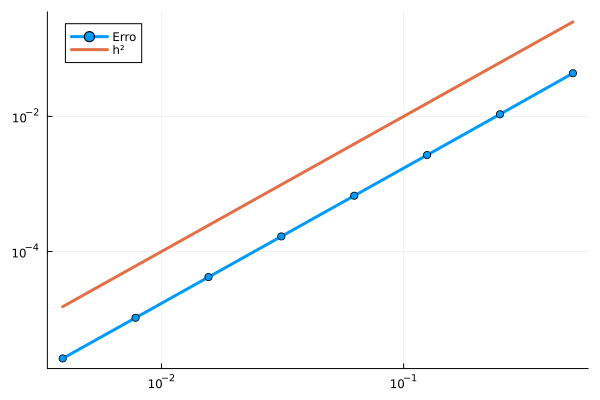

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.04348238097921159
 0.010743010677693513
 0.0026778734368088863
 0.0006689773116647823
 0.00016721365912275162
 4.180149798829526e-5
 1.0450258753703209e-5
 2.6125605465557472e-6

0.002677292877254924

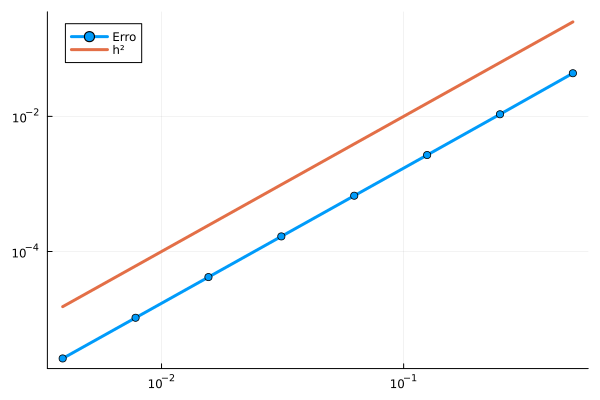

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.04348238097921159
 0.010738115378414273
 0.002677292877254924
 0.0006689540991830255
 0.0001672241317293539
 4.180616488638084e-5
 1.0451680853238689e-5
 2.612947926098062e-6

0.00917961827268254

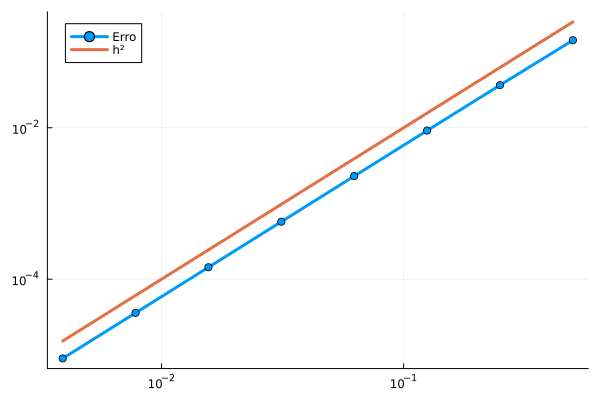

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.14306074758302456
 0.0365365459810257
 0.00917961827268254
 0.0022976973807414098
 0.0005745979061840725
 0.000143660301794704
 3.591576899031968e-5
 8.978999064912692e-6

0.009162398528114908

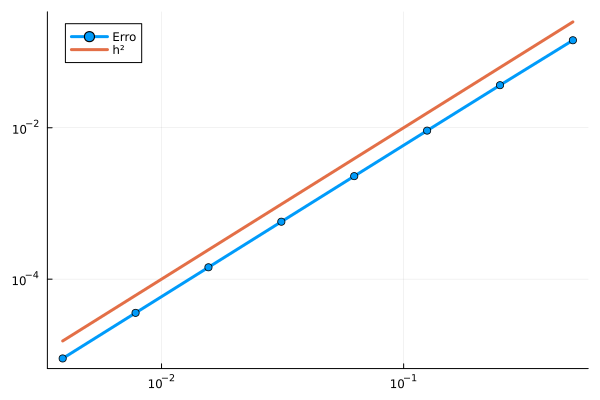

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.14306074758302456
 0.03647300030742202
 0.009162398528114908
 0.0022936875256525865
 0.0005736569940907007
 0.00014343410140797835
 3.5860423239375945e-5
 8.965318326230535e-6

0.009182152348950274

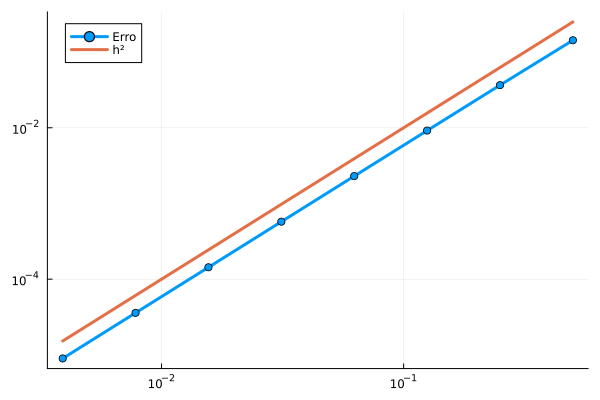

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.14306074758302456
 0.03654207308936446
 0.009182152348950274
 0.002298426253163585
 0.0005747866733774783
 0.00014370791757222827
 3.592769991013887e-5
 8.98198469368731e-6

0.010743010677693458

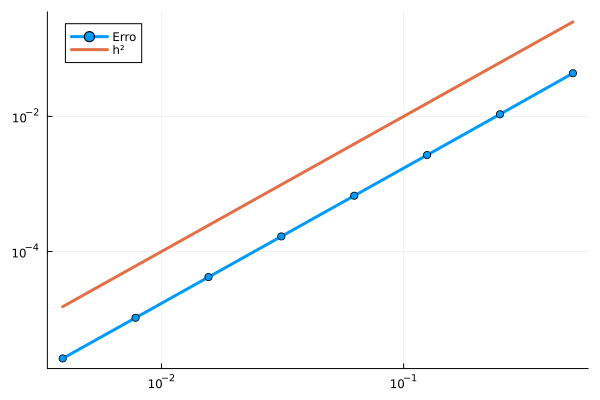

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.04348238097921159
 0.010743010677693458
 0.0026778734368087345
 0.0006689773116663603
 0.0001672136591134662
 4.180149809100497e-5
 1.0450257388703644e-5
 2.612559041622863e-6

0.0028527216536727313

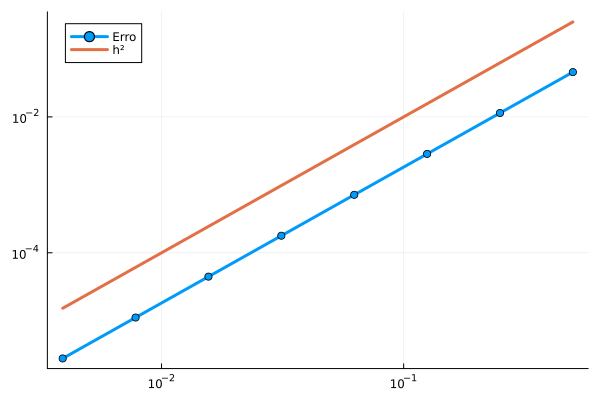

8-element Vector{Float64}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

8-element Vector{Float64}:
 0.045643546458763826
 0.01141088661469096
 0.0028527216536727313
 0.0007131804134181855
 0.0001782951033545439
 4.4573775838632476e-5
 1.114344395965576e-5
 2.785861061763246e-6

In [35]:
test_cases = 7
power = 8

for case in 1:test_cases
    display(solve_problem(get_test_data(case)...))
    
    h_list, errors_list = convergencia(get_convergence_test_data(case, power)...)
    plot_error_curves(h_list, errors_list)

    display(h_list)
    display(errors_list)
end